***Импортируем библиотеки***

In [5]:
import pandas as pd
import scipy.stats as st
import seaborn as sns

***Считываем данные***

In [2]:
df = pd.read_csv('~/data/dating_data.csv')

In [3]:
df

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


In [4]:
df[['user_id_1', 'user_id_2']].duplicated().sum()

0

Пары не дублируются, значит, мы не сможем посмотреть разницу работы алгоритмов на одних и тех же парах

In [6]:
df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

Пропущенных значений нет

***Разбиваем датафрейм на 2 группы - старый алгоритм и новый***

In [7]:
old = df[df['group'] == 0][['user_id_1', 'user_id_2', 'is_match']]
old

,user_id_1,user_id_2,is_match
2,423,677,0
4,969,155,1
5,227,162,0
8,223,295,0
10,825,388,0
...,...,...,...
14502,535,545,0
14503,128,268,0
14505,544,600,0
14506,903,505,0


In [8]:
new = df[df['group'] == 1][['user_id_1', 'user_id_2', 'is_match']]
new

,user_id_1,user_id_2,is_match
0,79,91,1
1,716,353,1
3,658,165,1
6,435,16,0
7,602,327,0
...,...,...,...
14508,527,647,0
14510,455,770,0
14511,260,6,1
14512,885,812,1


В данной ситуации у нас есть только один показатель - замэтчилась ли пара. Очевидное решение - посчитать количество мэтчей, но группы неравномерны - старым алгоритмом пользовались 4792 пары, а новым - 9722.   
Таким образом, разумнее будет посчитать коверсию - процент перехода из обычной пары в замэтченую.     
Примем утверджение о том, что чем выше конверсия, тем лучше алгоритм.

In [9]:
print('old algorythm converion is:', old[old['is_match'] == 1]['is_match'].count() / old['is_match'].count() * 100)
print('new algorythm converion is:', new[new['is_match'] == 1]['is_match'].count() / new['is_match'].count() * 100)

old algorythm converion is: 19.490818030050082
new algorythm converion is: 40.20777617774121


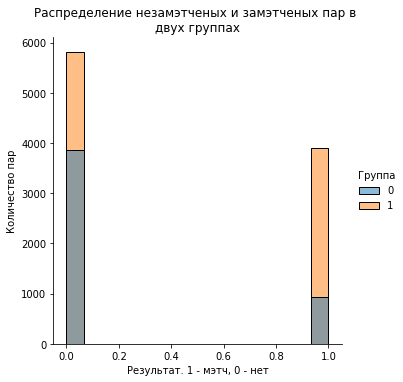

In [16]:
ax_dating = sns.displot(data=df.rename(columns={'group': 'Группа'}), x='is_match', hue='Группа')
ax_dating.set(title='Распределение незамэтченых и замэтченых пар в \nдвух группах',
              ylabel='Количество пар',
              xlabel='Результат. 1 - мэтч, 0 - нет')

Итак, целевая метрика - конверсия. А значит, используем хи-квадрат. Построим таблицу сопряженности.

In [15]:
cross = pd.crosstab(columns=df['is_match'], index=df['group'])
cross

is_match,0,1
group,,
0,3858,934
1,5813,3909


Теперь проведем тест.

In [20]:
result = st.chi2_contingency(cross)
result

(618.6889141576198,
 1.4418299163662586e-136,
 1,
 array([[3193.01584677, 1598.98415323],
        [6477.98415323, 3244.01584677]]))

Pvalue равно 1.4418299163662586e-136 - это микроскопическое значение. Chi2_contingency проверяет нулевую гипотезу о том, что распределения одинаковы. Pvalue достаточно мал, чтобы отвергнуть нулевую гипотезу - мы принимаем, что распределения отличаются. Из уже посчитанных конверсий мы знаем, что у нового алгоритма мэтчей больше. Теперь мы выяснили, что разница статистически значима. В начале мы приняли утверждение о том, что чем выше конверсия, тем лучше алгоритм.   
***Вывод: Выкатываем новый алгоритм.***
